In [1]:
import os
import numpy as np
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

In [28]:

data_dir = '../results/gcomc/chla/'
varname = 'chlor_a'
cmin, cmax = 10, 30
# Initialize a dictionary to hold the data for each month.
monthly_data = {month: [] for month in range(1, 13)}
yearly_data = {year: [] for year in range (2018, 2024)}
# Assuming these are the coordinates you want to crop to
# lat_min_crop, lat_max_crop = 34.3, 35.7  # Update these values as needed
# lon_min_crop, lon_max_crop = 138.3, 140.23  # Update these values as needed

# lat_min_crop, lat_max_crop = 34.5, 35.4
# lon_min_crop, lon_max_crop = 138.82, 139.9
lat_min_crop, lat_max_crop = 34.4, 35.7
lon_min_crop, lon_max_crop = 138.35, 140.2
# rectangle_coords = [(35.7,  138.35), (35.7, 140.2), (34.4, 140.2), (34.4,  138.35), (35.7,  138.35)]



In [29]:

# Loop through files and accumulate data
for fol in os.listdir(data_dir):
    print(data_dir+fol)
    for file_name in os.listdir(data_dir + fol):
        if file_name.endswith('.nc'):
            # year, month = int(file_name[1:5]), int(file_name[5:7])  # Modis
            year, month = int(file_name[2:6]), int(file_name[6:8])   # GCOMC
            
            file_path = os.path.join(data_dir + fol, file_name)
            with Dataset(file_path, 'r') as nc:
                data = np.ma.squeeze(nc[varname][:])
                lat = nc['lat'][:]
                lon = nc['lon'][:]
                
                # Find indices for cropping
                lat_inds = np.where((lat >= lat_min_crop) & (lat <= lat_max_crop))[0]
                lon_inds = np.where((lon >= lon_min_crop) & (lon <= lon_max_crop))[0]
                # Crop data
                   # Now add a check to ensure the indices are within the bounds of the array
                if lat_inds.size > 0 and lon_inds.size > 0:
                   # Adjust the slicing based on the actual dimensions of sds
                   data_cropped = data[lat_inds, :][:, lon_inds]  # This is the updated line for a 2D array
                   lat_cropped = lat[lat_inds]
                   lon_cropped = lon[lon_inds]
                else:
                   print("No data within specified crop bounds.")
                
                # print(np.ma.mean(data_cropped))    
                # sds_cropped = sds[:, lat_inds, :][:, :, lon_inds]  # Assuming sds has a shape of [time, lat, lon]
                lat_cropped = lat[lat_inds]
                lon_cropped = lon[lon_inds]
                # Convert masked values to NaN
                data_cropped = np.where(data_cropped.mask, np.nan, data_cropped)

                monthly_data[month].append(data_cropped)
                yearly_data[year].append(data_cropped)

../results/gcomc/chla/2018
../results/gcomc/chla/2019
../results/gcomc/chla/2020
../results/gcomc/chla/2021
../results/gcomc/chla/2022
../results/gcomc/chla/2023


In [4]:
# Compute the average for each month while ignoring NaN values
monthly_averages = {month: np.nanmean(np.stack(data_list), axis=0) for month, data_list in monthly_data.items() if data_list}

print(len(monthly_averages))
for month, data in monthly_averages.items():
    plt.figure()
    extent = [lon_cropped.min(), lon_cropped.max(), lat_cropped.min(), lat_cropped.max()]
    lon_0, lat_0 = (lon_cropped.min() + lon_cropped.max()), (lat_cropped.min() + lat_cropped.max()) / 2
    m = Basemap(llcrnrlon=lon_cropped.min(), llcrnrlat=lat_cropped.min(), 
                    urcrnrlon=lon_cropped.max(), urcrnrlat=lat_cropped.max(), resolution='i', 
                    lon_0=lon_0, lat_0=lat_0, projection='merc')
    
    #  m.drawcoastlines()
    #  m.drawparallels(np.arange(int(np.min(lat)), int(np.max(lat)) + 1, 1), labels=[1,0,0,0])
    #  m.drawmeridians(np.arange(int(np.min(lon)), int(np.max(lon)) + 1, 1), labels=[0,0,0,1])
    if lat.ndim > 1:
      lat = lat[:, 0]
    if lon.ndim > 1:
      lon = lon[0, :]
    
    lon_edges = np.linspace(lon_cropped.min(), lon_cropped.max(), data.shape[1]+1)
    lat_edges = np.linspace(lat_cropped.min(), lat_cropped.max(), data.shape[0]+1)

    lon_mesh, lat_mesh = np.meshgrid(lon_edges, lat_edges)

    x, y = m(lon_mesh, lat_mesh)
    
   #  cs = m.pcolormesh(x, y, data, shading='flat', cmap=plt.cm.jet)
    cs = m.pcolormesh(x, y, data,  cmap=plt.cm.jet, vmin=0, vmax=10)
    plt.colorbar(cs, orientation='vertical', shrink=0.5)
    plt.title(f'Average SST for Month {month:02d}')
    plt.savefig(f'average_sst_{month:02d}.png', dpi=300)
    plt.close()


0


In [30]:

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plot, colors
# Define your color list in hex
hex_colors_chl = [
    '#3500a8', '#0800ba', '#003fd6',
    '#00aca9', '#77f800', '#ff8800', 
    '#b30000', '#920000', '#880000'
]
# hex_colors_sst = [
#    '#ffffff','#b7f0ae','#21f600','#0000FF','#FDFF92','#FF2700','#d600ff'
# ]
# hex_colors_sst = [
#     '#ffffff',  # white
#     '#e8f8ff',  # very light blue (cold)
#     '#b7f0ae',  # light green
#     '#8ae68a',  # intermediate green
#     '#21f600',  # bright green (warm)
#     '#7bff7b',  # intermediate between green and blue
#     '#0000FF',  # blue
#     '#7f92ff',  # light blue (getting warmer)
#     '#FDFF92',  # light yellow (warm)
#     '#FFD700',  # gold
#     '#FFA500',  # orange
#     '#FF2700',  # red (hot)
#     '#e60000',  # deep red (hotter)
#     '#d600ff',  # purple (very hot)
#     '#a500ff',  # deep purple (even hotter)
# ]
# hex_colors_sst = [
# "#90EE90", "#2E8B57", "#228B22", "#006400",
#    "#FFFFE0", "#FFD700", "#CC7722", "#DAA520",
#     "#FFE5B4", "#FF7F50", "#FFA500", "#CC5500",
#    "#FFC0CB", "#FF0000", "#DC143C", "#800000"
# ]
# hex_colors_sst = [

#     "#90EE90",  # Light Green 1
#     "#ADFF2F",  # Light Green 2
#     "#CCE599",  # Light Green 3
#     "#FFFFE0",  # Light Yellow 1
#     "#FFF59D",  # Light Yellow 2
#     # "#FFEB4C",  # Light Yellow 3
#     "#FFD700",  # Gold (Light Orange 1)
#     "#FFA500",  # Orange 2
#     # "#FF8C00",  # Light Orange 3
#     "#FFC0CB",  # Light Pink (Light Red 1)
#     "#FF9999",  # Light Red 2
#     "#FF7F50"   # Coral (Light Red 3)
# ]
# hex_colors_sst = [
#     '#FF2700',  # Red
#     '#FFA500',  # Orange
#     '#FDFF92',  # Yellow
#     '#b7f0ae',  # Light Green
#     '#21f600',  # Bright Green
#     '#0000FF',  # Blue
#     '#4b0082',  # Indigo
#     '#d600ff',  # Purple (Violet)
#     '#a500ff',  # Deep Purple (darker Violet)
#     '#ffffff'  # White (for peak temperatures)
# ]

# # Convert hex color list to RGB
rgb_colors = [colors.hex2color(color) for color in hex_colors_chl]
# rgb_colors = ["blue","#6495ED", "#008080","green","#28B463", "yellow","#FFC300","#FFBF00","orange","#DE3163","red","#CD5C5C"]
# rgb_colors = ["green","lightgreen", "yellow", "orange", "#FF474C", "red"]
monthly_averages = {month: np.nanmean(np.stack(data_list), axis=0) for month, data_list in monthly_data.items() if data_list}
yearly_averages = {year: np.nanmean(np.stack(data_list), axis=0) for year, data_list in yearly_data.items() if data_list}


C:\Users\Robel\AppData\Local\Temp\ipykernel_32544\3101662701.py:67: RuntimeWarning: Mean of empty slice
  monthly_averages = {month: np.nanmean(np.stack(data_list), axis=0) for month, data_list in monthly_data.items() if data_list}
C:\Users\Robel\AppData\Local\Temp\ipykernel_32544\3101662701.py:68: RuntimeWarning: Mean of empty slice
  yearly_averages = {year: np.nanmean(np.stack(data_list), axis=0) for year, data_list in yearly_data.items() if data_list}


In [112]:
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.colors import Colormap

# # Define color positions within the range (0 to 1)
# color_positions = [0, 0.25, 0.5, 0.75, 0.85, 1]

# # Define desired colors
# rgb_colors = ["green","lightgreen", "yellow", "orange", "#FF474C", "red"]

# # Create a colormap object
# cmap = Colormap(name='sst_colors', colors=rgb_colors, positions=color_positions)

# # Function to slightly lighten colors (adjust factor for desired lightness)
# def lighten_color(color, factor=0.1):
#   red, green, blue, alpha = color
#   return tuple([min(1.0, c + factor) for c in (red, green, blue)])

# # Generate list of colors with smooth transitions and slight lightening
# num_steps = 256
# sst_colors = [lighten_color(cmap(i)) for i in np.linspace(0, 1, num_steps)]


TypeError: Colormap.__init__() got an unexpected keyword argument 'colors'

12
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-0.4717279076576233 -0.4424894154071808 -0.44258639216423035 ...
  -0.5839259028434753 -0.6004795432090759 -0.5848819613456726]
 [-0.42394036054611206 -0.4415576756000519 -0.4341062605381012 ...
  -0.5751879811286926 -0.6513206362724304 -0.623458743095398]
 [-0.4186544716358185 -0.430763304233551 -0.42130935192108154 ...
  -0.6081382632255554 -0.6115477681159973 -0.5925444960594177]]
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-0.5213435888290405 -0.5344158411026001 -0.5422989130020142 ...
  -0.579142153263092 -0.5311603546142578 -0.6585323214530945]
 [-0.5498813986778259 -0.5428032875061035 -0.5336658954620361 ...
  -0.6453973650932312 -0.6514103412628174 -0.64835125207901]
 [-0.5351715087890625 -0.5507181882858276 -0.512009859085083 ...
  -0.656862199306488 -0.6512933373451233 -0.6478770971298218]]
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... 

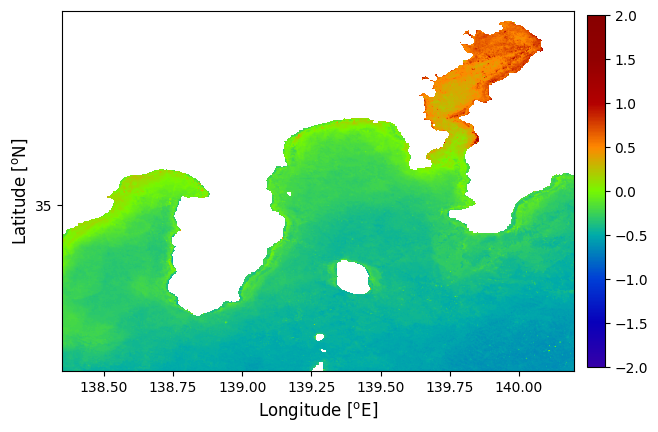

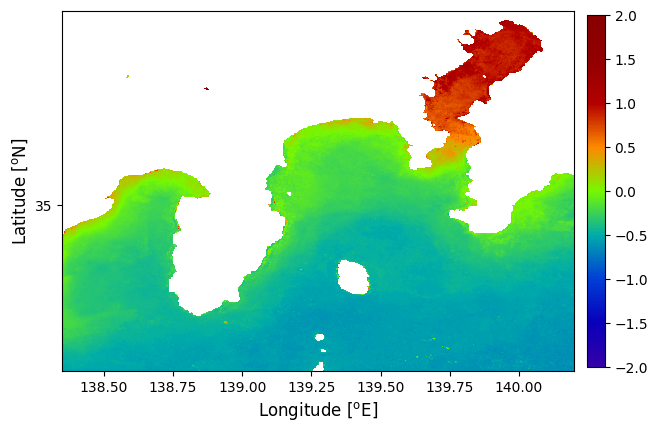

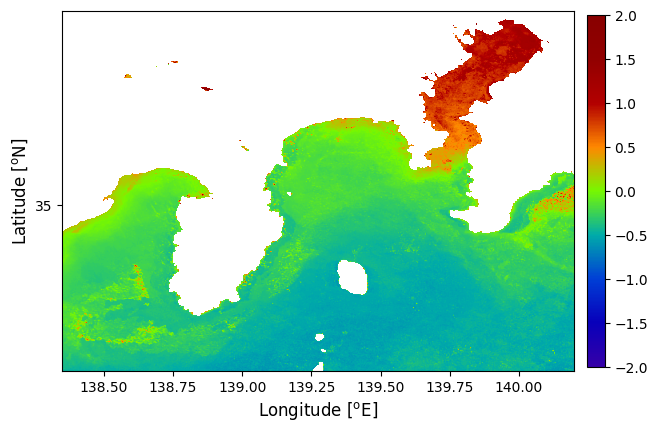

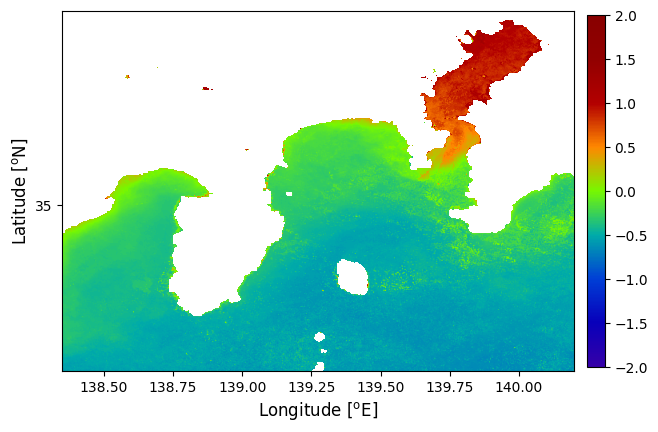

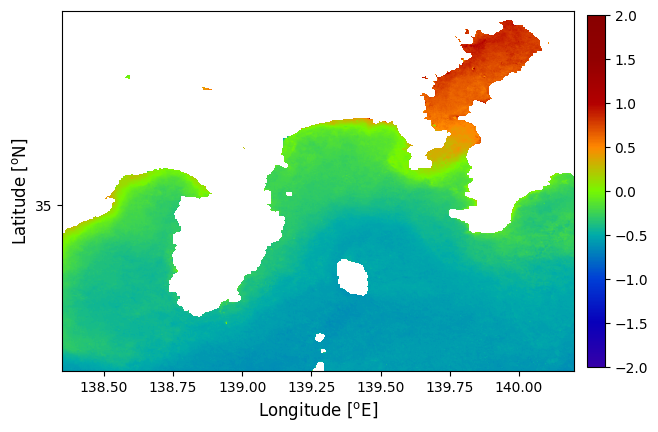

In [25]:
cmin, cmax = -2,2
# cmin, cmax = 10, 30
print(len(monthly_averages))

for year, sds_cropped in yearly_averages.items():    # Visualisation with basemap
    # print("runnign")
    if len(lon_cropped.shape) == 1:
        lon_cropped, lat_cropped = np.meshgrid(lon_cropped, lat_cropped)
    lon_0, lat_0 = (lon_cropped.min() + lon_cropped.max()), (lat_cropped.min() + lat_cropped.max()) / 2
    m = Basemap(llcrnrlon=lon_cropped.min(), llcrnrlat=lat_cropped.min(), 
                        urcrnrlon=lon_cropped.max(), urcrnrlat=lat_cropped.max(), resolution='i', 
                        lon_0=lon_0, lat_0=lat_0, projection='merc')

    # print(sds_cropped)
    sds_cropped_log = np.ma.masked_less_equal(sds_cropped, 0)  # Mask non-positive values
    sds_cropped_log = np.ma.log10(sds_cropped_log)  # Apply log10 to the data
    print(sds_cropped_log)
    sds_cropped = sds_cropped_log

    # Visualisation without basemap
    # Adjust figsize to change the aspect ratio
    fig, ax = plot.subplots(figsize=(7, 6))  # Adjust the width and height to better suit your data aspect ratio

    # figure bounds
    extent = [lon_cropped.min(), lon_cropped.max(), lat_cropped.min(), lat_cropped.max()]

    # Land mask
    # mask = np.where(~sds_cropped.mask, np.nan, 0)
    ax.imshow(sds_cropped, cmap='gray', vmin=-2, vmax=0, extent=extent)

    # Create a colormap object
    custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

    # print(sds_cropped_log.max(), sds_cropped_log.min())

    # We no longer use LogNorm here since we've manually applied log10
    # ims = ax.imshow(sds_cropped_log, cmap='jet', extent=extent)
    # ims = ax.imshow(sds_cropped,vmin=cmin, vmax=cmax,   extent=extent)

    ims = ax.imshow(sds_cropped,vmin=cmin, vmax=cmax,  cmap=custom_colormap, extent=extent)

    # # Figure labels
    ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
    ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
    ax.set_yticks(range(int(np.ceil(lat_cropped.min())), int(np.ceil(lat_cropped.max())), 1))
    # ax.set_title(time[0].strftime('%b %Y'))

    # # Colourbar
    cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025,  aspect=20)
    # cbar.set_label('log10(Chl-a) Conc. mg/m^3', fontsize="12")

    # ticks = [ims.get_clim()[0],0, ims.get_clim()[1]] # This gets the color limit range
    # cbar.set_ticks(ticks)
    # cbar.set_ticklabels([f'{ticks[0]:.2f}', f'{ticks[1]:.2f}', f'{ticks[2]:.2f}']) # Format as desired

    # Small Sagami Bay
    lat_min, lat_max = 35.124, 35.34
    lon_min, lon_max = 139.115, 139.68
    plt.savefig(f'yearly/GCOMC-average_chla_{year:02d}.png', dpi=300, bbox_inches='tight')
